In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops
import diffimg
import scipy.special as special

In [2]:
def beta_correction( f, a = 2.0, b = 2.0 ):
    x = np.linspace( 0, 1, 256 )
    y = special.betainc( a, b, x ) * 255
    g = f.copy()
    nr, nc = f.shape[:2]
    for i in range(nr):
        for j in range(nc):
            g[i,j] = np.uint8(y[f[i,j]])
    return g

image is circle
correlation_mean = 0.5128967621269721
 correlation_std = 0.14127448287128086
threshold =  0.822


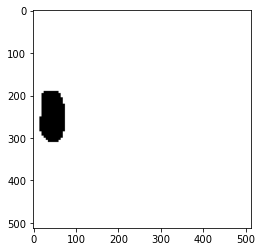

time: 41.093644 seconds


In [3]:
#輸入輸出影像檔名設定
input_fileName = 'image2.png'
output_fileName = 'detection2.png'

start = time.time()

#讀取圖片
image = cv2.imread(input_fileName)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#beta處理
image = beta_correction(image, a = 2.0, b = 2.0 )

size_filter = 25
offset = 5

nr,nc = image.shape[:2]
x_filter = int((nr)/offset)
y_filter = int((nc)/offset)

end_r = nr - size_filter + offset
end_c = nc - size_filter + offset

co_contrast = np.zeros((x_filter ,y_filter))
co_correlation = np.zeros((x_filter ,y_filter))
co_dissimilarity = np.zeros((x_filter,y_filter))

for i in range(0, end_r, offset):
    for j in range(0, end_c, offset):
        f = image[ i : i + size_filter , j : j + size_filter ]
        result = greycomatrix( f, [1],[0] )
        co_contrast[int(i/offset),int(j/offset)] = float(greycoprops(result, 'contrast'))
        co_correlation[int(i/offset),int(j/offset)] = float(greycoprops(result, 'correlation'))
        co_dissimilarity[int(i/offset),int(j/offset)] = float(greycoprops(result,'dissimilarity'))

#contrast
contrast_mean = round(np.mean(co_contrast))
contrast_std = round(np.std(co_contrast))
contrast_max = round(np.max(co_contrast))
#dissimilarity
dissimilarity_mean = round(np.mean(co_dissimilarity))
dissimilarity_std = round(np.std(co_dissimilarity))
#correlation
correlation_mean = np.mean(co_correlation)
correlation_std = np.std(co_correlation)

#門檻值設定
contrast_mean_threshold = 125        #circle大於 125.033578 
contrast_std_threshold = 39         #circle大於 38.544783 
contrast_max_threshold = 246         #circle大於 246.250000 
dissimilarity_mean_threshold = 8.46   #circle大於 8.459510 
dissimilarity_std_threshold = 2.3    #circle大於 2.244871 
circle_count = 0
is_circle = True

#過關，判斷線性or圓形
if contrast_mean > contrast_mean_threshold:circle_count+=1
if contrast_std > contrast_std_threshold:circle_count+=1
if contrast_max > contrast_max_threshold:circle_count+=1
if dissimilarity_mean > dissimilarity_mean_threshold:circle_count+=1
if dissimilarity_std > dissimilarity_std_threshold:circle_count+=1
if circle_count >= 3:
    print('image is circle')
else:
    print('image is linear')
    is_circle = False
print(f'correlation_mean = {correlation_mean}\n correlation_std = {correlation_std}')

#建立空白的偵測影像
detection = np.full((nr, nc), 255,dtype='uint8')

#決定影像的門檻值
if is_circle:
    threshold = 0.822
    size = 15
else:
    size = 10
    if correlation_std > 0.15:
        threshold = correlation_mean + (correlation_std*0.75)
    else:
        threshold = correlation_mean + correlation_std
print('threshold = ',threshold) 

#將瑕疵點標記出來
for i in range(x_filter):
    for j in range(y_filter):
        if co_correlation[i,j] > threshold:
            for m in range(j*offset,j*offset+size):
                for n in range(i*offset,i*offset+size):
                    try:
                        detection[n][m] = 0
                    except:
                        pass

plt.imshow(detection,cmap='gray')
plt.show()
cv2.imwrite(output_fileName, detection)
    
end = time.time()
print("time: %f seconds" % (end-start))

In [4]:
im1="image2_groundtruth.png"
im2="detection2.png"
print(diffimg.diff(im1,im2))

0.0085601806640625
